# Platt Scaling

In [91]:
%matplotlib notebook
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle':'--'})
np.random.seed(1)
warnings.filterwarnings('ignore')

In [255]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

In [4]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls',
                  header=1)

target = 'default payment next month'
features = [x for x in df.columns if x not in (target, 'ID')]

In [278]:
X, y = load_breast_cancer().data, load_breast_cancer().target
X, y = df[features], df[target]

print('Number of total samples:    {}'.format(X.shape[0]))
print('Number of positive samples: {}'.format(y.sum()))
# do some undersampling, to make the class more balanced
idx_neg = X[y==0].sample(y.sum()).index.values
idx_pos = X[y==1].index.values
idx = np.concatenate([idx_neg, idx_pos])
X = X.iloc[idx, :].reset_index(drop=True)
y = y.iloc[idx].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y)
# reserve for platt scaling
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train)

clfs = [
    [RandomForestClassifier(n_estimators=100, max_depth=3), 'Random Forrst'],
#     [GradientBoostingClassifier(n_estimators=100, max_depth=3), 'Gradient Boost'],
    [xgb.XGBClassifier(n_estimators=100, max_depth=3), 'xgb'],
    [AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100), 'AdaBoost'],
#     [KNeighborsClassifier(n_neighbors=30, leaf_size=10) ,'kNN'],
#     [MLPClassifier(hidden_layer_sizes=(200, 100, 50, 20), activation='logistic', early_stopping=True), 'NN']
]


def fitting(clf):
    print('\n====== {} ====='.format(clf.__class__.__name__))
    print("Training...")   
    clf.fit(X_train, y_train)    
    print('AUC on train set:    {:6.3f}'.format(
        roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])))
    print('AUC on test set:     {:6.3f}'.format(
        roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
    print('Logloss on test set: {:6.3f}'.format(
        log_loss(y_test, clf.predict_proba(X_test)[:,1])))
    
    return 

def platt(y_score, y_true):
    model_platt = LogisticRegression(C=1e10)
    model_platt.fit(np.matrix(y_score).T, y_true)
    
    return model_platt

def pred_with_platt(X, y, clf, model_platt):
    y_pred = clf.predict_proba(X)[:,1]
    y_cal = model_platt.predict_proba(np.matrix(y_pred).T)[:,1]
    print('AUC:     {:6.3f}'.format(
        roc_auc_score(y, y_cal)))
    print('Logloss: {:6.3f}'.format(
        log_loss(y, y_cal)))
    
    return y_cal

Number of total samples:    30000
Number of positive samples: 6636


In [279]:
for x in clfs:
    fitting(x[0])
    model_platt = platt(x[0].predict_proba(X_cal)[:,1], y_cal)
    _ = pred_with_platt(X_test, y_test, x[0], model_platt)
    x.append(model_platt)


====== RandomForestClassifier =====
Training...
AUC on train set:     0.776
AUC on test set:      0.771
Logloss on test set:  0.585
AUC:      0.771
Logloss:  0.572

====== XGBClassifier =====
Training...
AUC on train set:     0.826
AUC on test set:      0.785
Logloss on test set:  0.557
AUC:      0.785
Logloss:  0.557

====== AdaBoostClassifier =====
Training...
AUC on train set:     0.932
AUC on test set:      0.715
Logloss on test set:  0.683
AUC:      0.715
Logloss:  0.676


In [280]:
def plot_prob_dist(y_pred, y_true, label='', fig_num=0):
    plt.close(fig_num)
    plt.figure(fig_num)
    df = pd.DataFrame(data={'pred':y_pred, 'true':y_true.values})
    sns.distplot(df[df['true']==0]['pred'], kde=False, bins=100, label='0')
    sns.distplot(df[df['true']==1]['pred'], kde=False, bins=100, label='1')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title(label)
    plt.legend()
    plt.tight_layout()

<IPython.core.display.Javascript object>


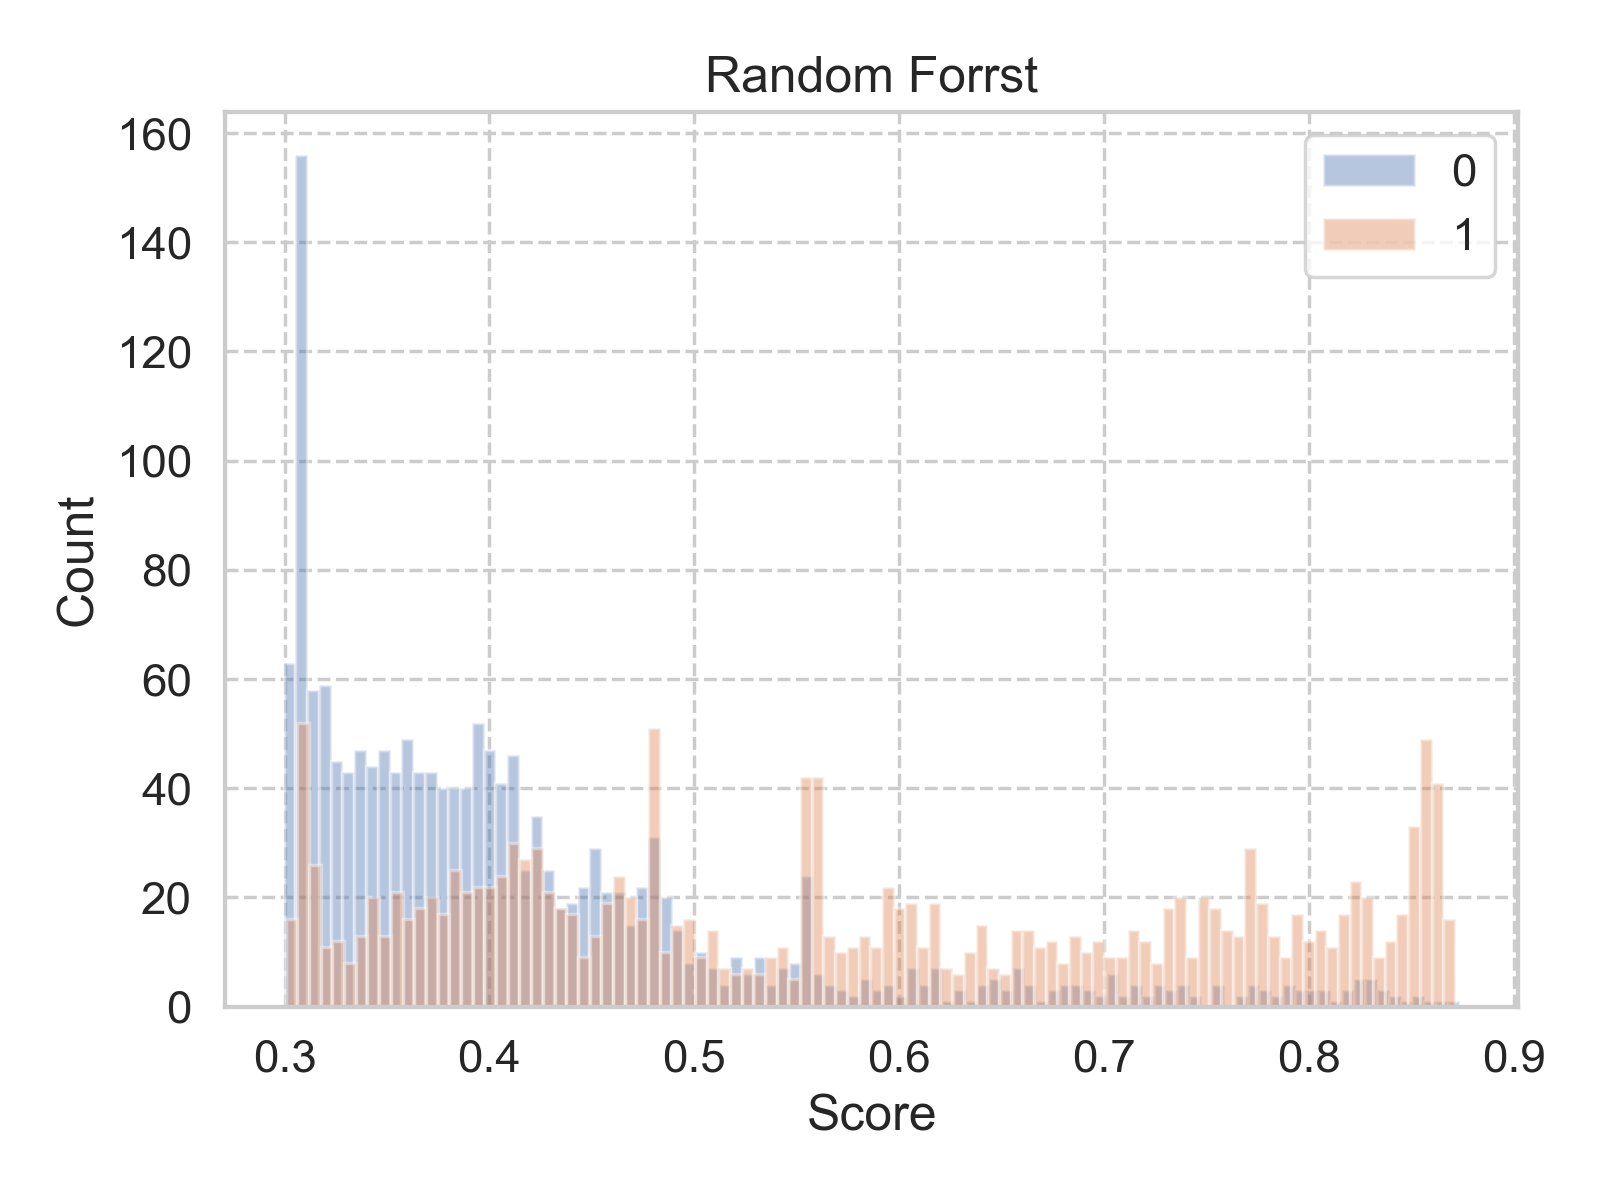

<IPython.core.display.Javascript object>


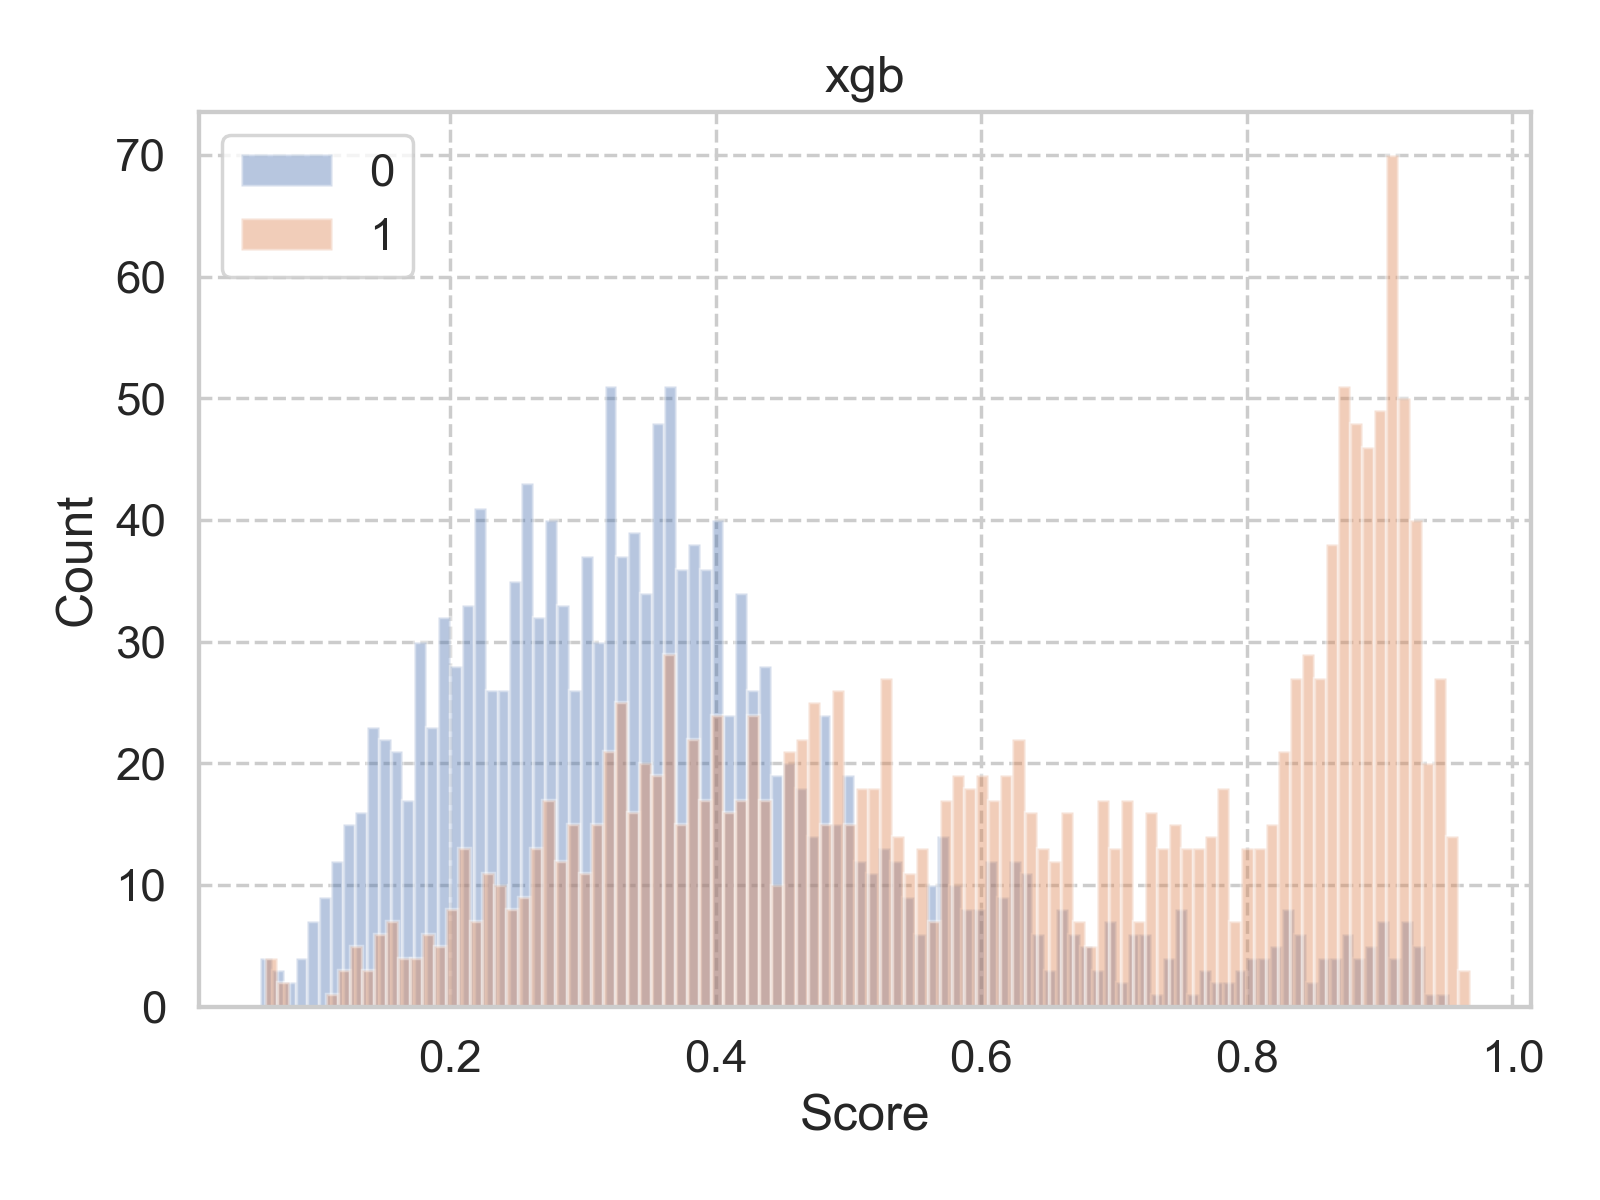

<IPython.core.display.Javascript object>


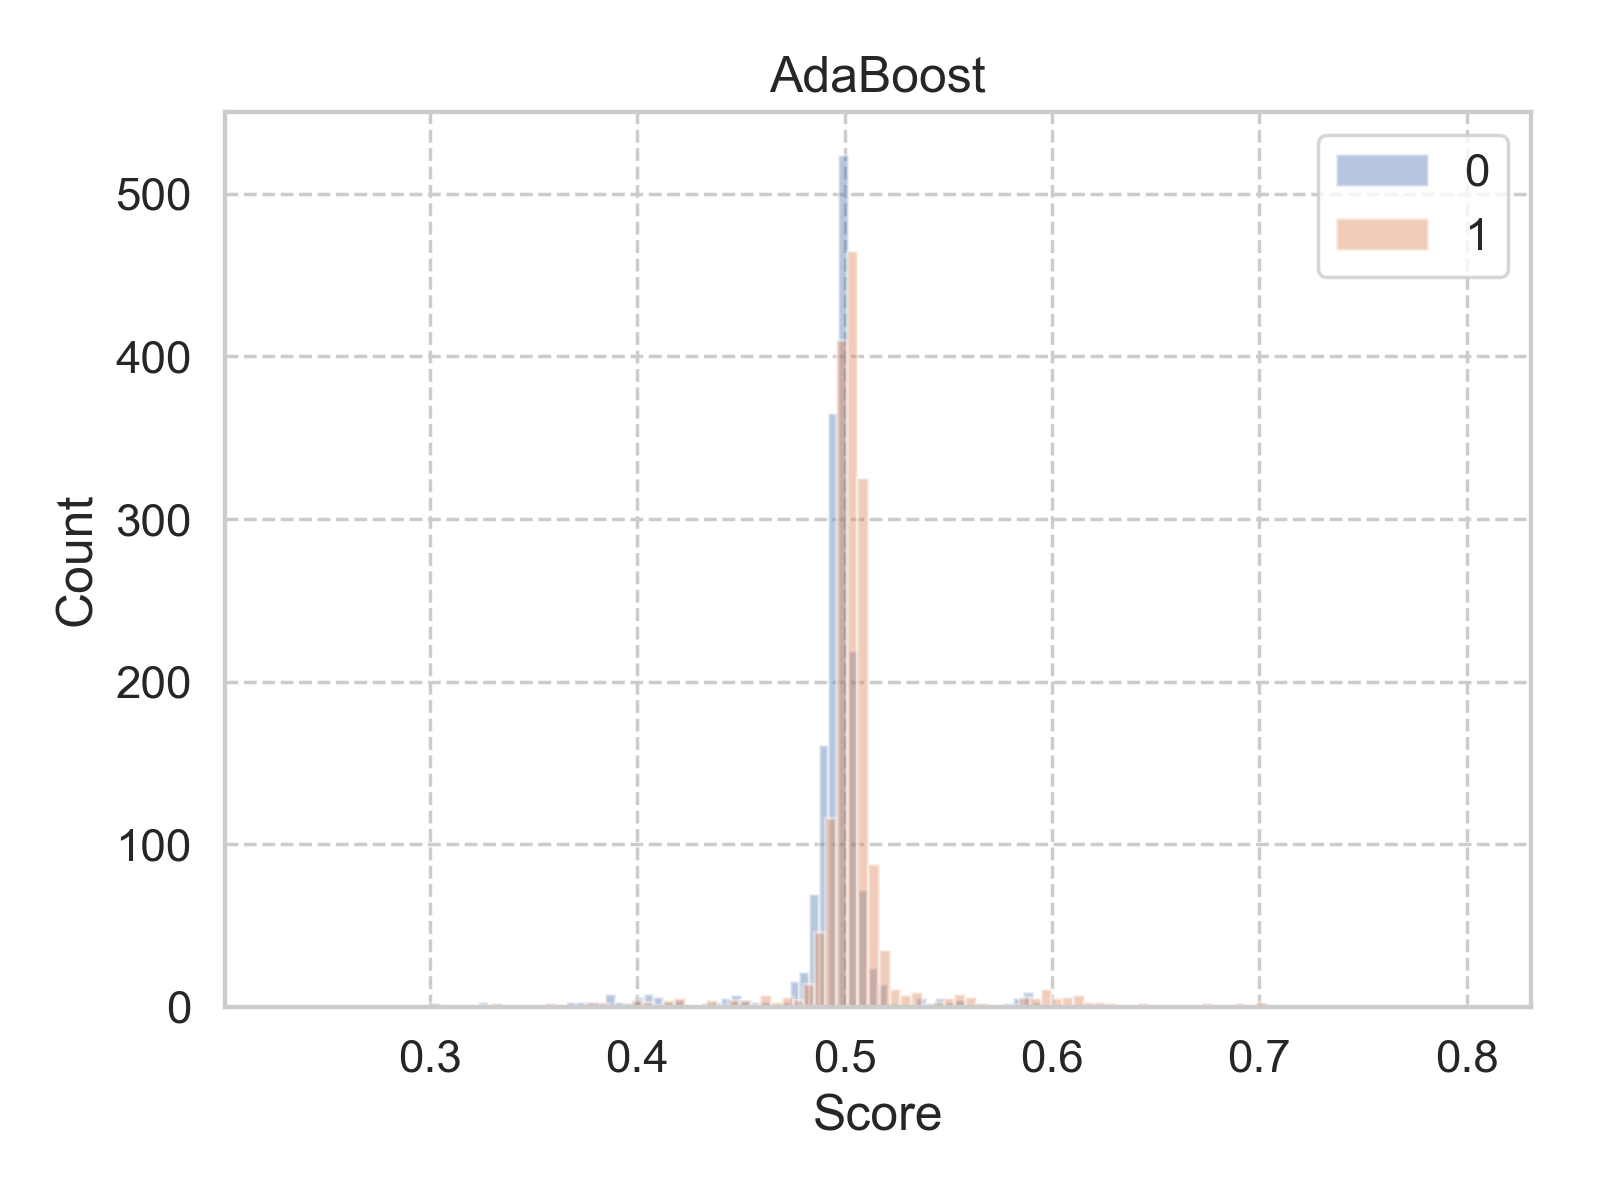

In [281]:
for i, x in enumerate(clfs):
    plot_prob_dist(x[0].predict_proba(X_test)[:, 1], y_test, x[1], i)

In [247]:
def reliability_diagram(y_true, y_pred, N=20):
    paired = np.c_[y_pred, y_true]
    paired = paired[np.argsort(paired[:,0])]
    length = paired.shape[0]
    mean_proba, mean_true = [], []
    start_idx = 0
    size = int(np.ceil(length/N))
    while start_idx < length:
        mean_proba.append(paired[start_idx:start_idx+size, 0].mean())
        mean_true.append(paired[start_idx:start_idx+size, 1].mean())
        start_idx += size
    return (mean_proba, mean_true)

def plot_reliability_diagram(mean_proba, mean_true, label='', model_platt=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.scatterplot(mean_proba, mean_true, alpha=0.7, label=label)
    plt.plot([0,1], [0,1], 'k--')
    if model_platt:
        x = np.linspace(0, 1, 100)
        y = model_platt.predict_proba(np.matrix(x).T)[:, 1]
        plt.plot(x, y)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()

<IPython.core.display.Javascript object>


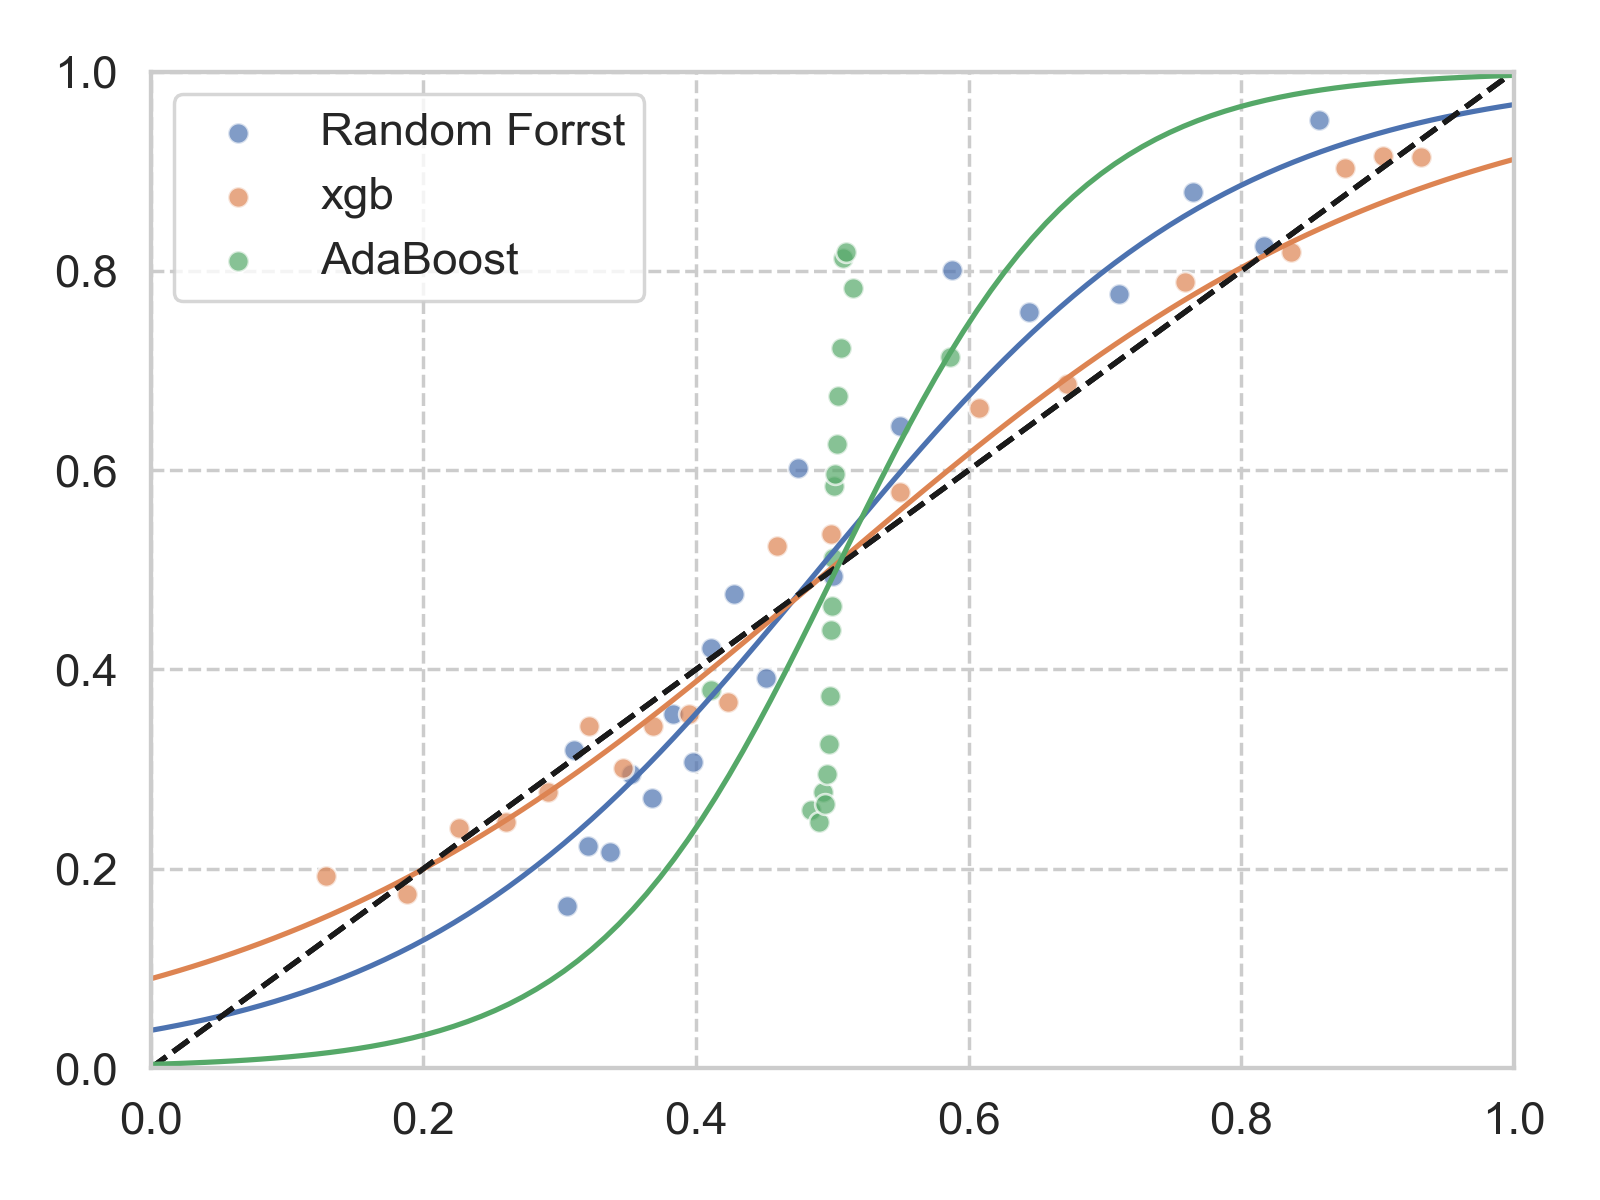

In [282]:
fig, ax = plt.subplots()
for i, x in enumerate(clfs):
    plot_reliability_diagram(
        *reliability_diagram(y_test, x[0].predict_proba(X_test)[:,1]), x[1], x[2], ax=ax)

AUC:      0.771
Logloss:  0.572


<IPython.core.display.Javascript object>


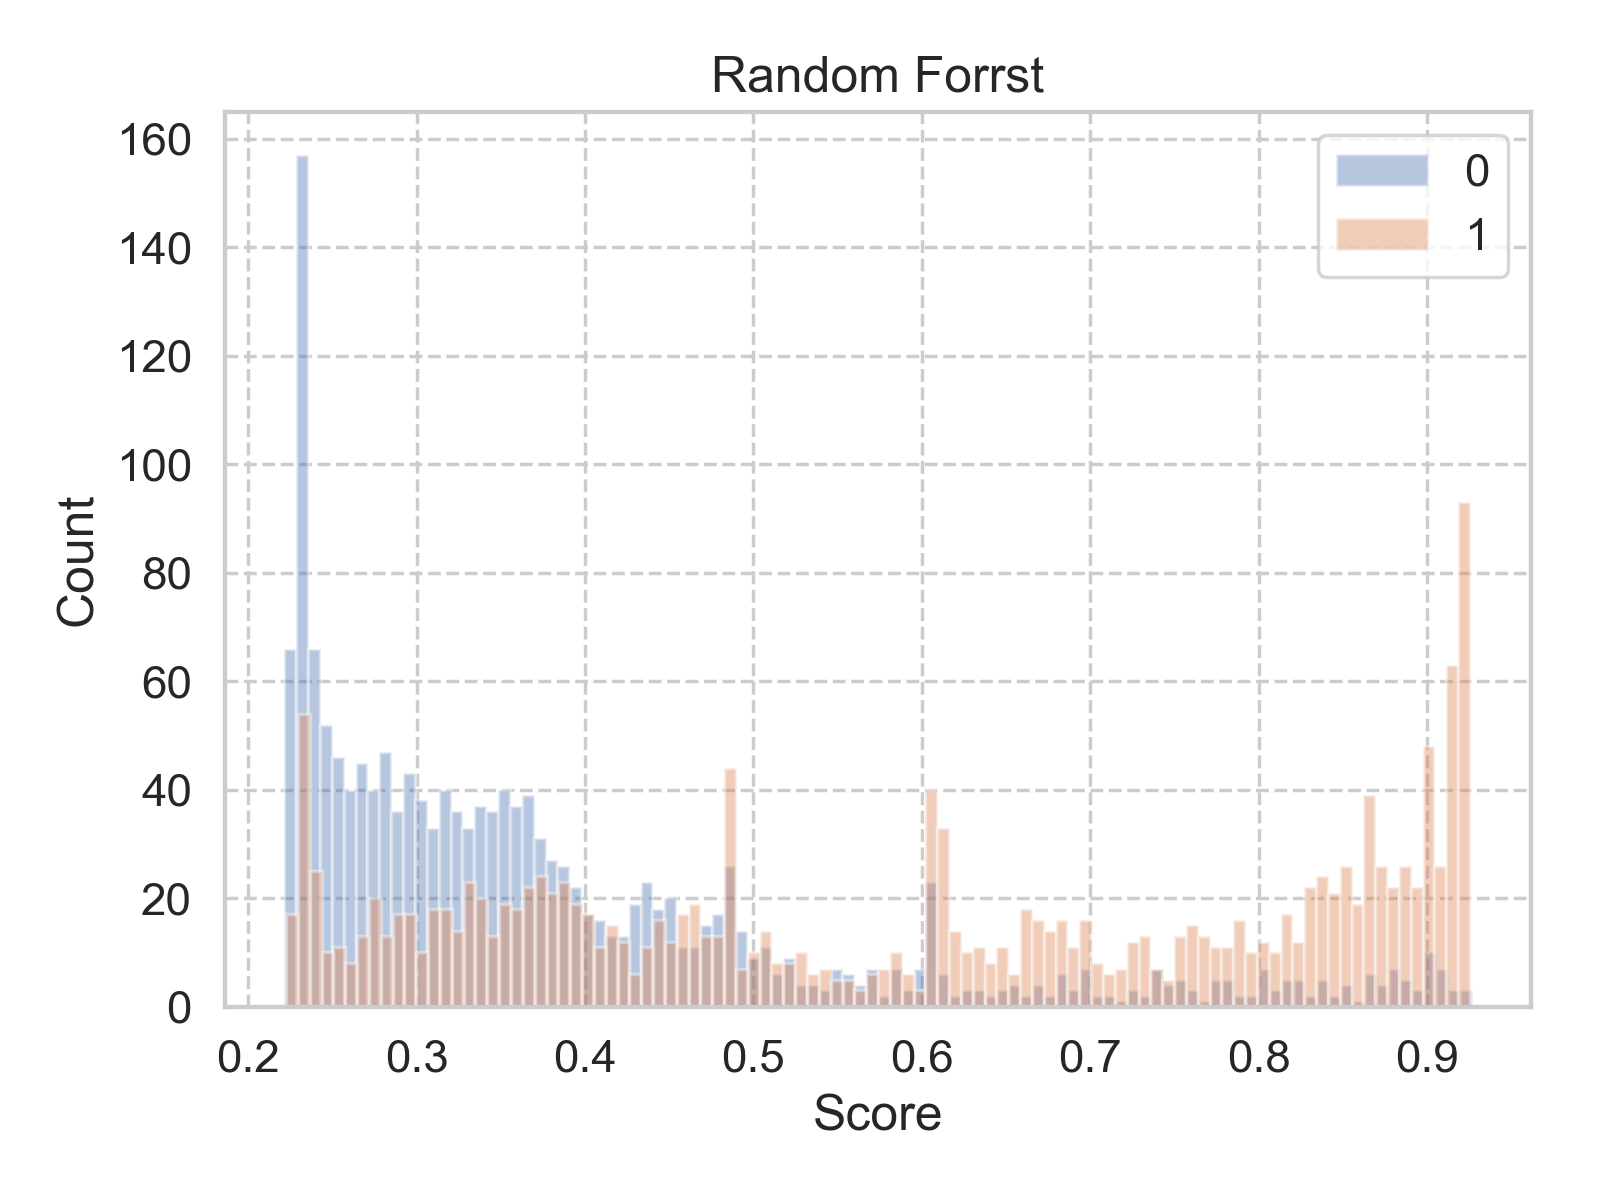

AUC:      0.785
Logloss:  0.557


<IPython.core.display.Javascript object>


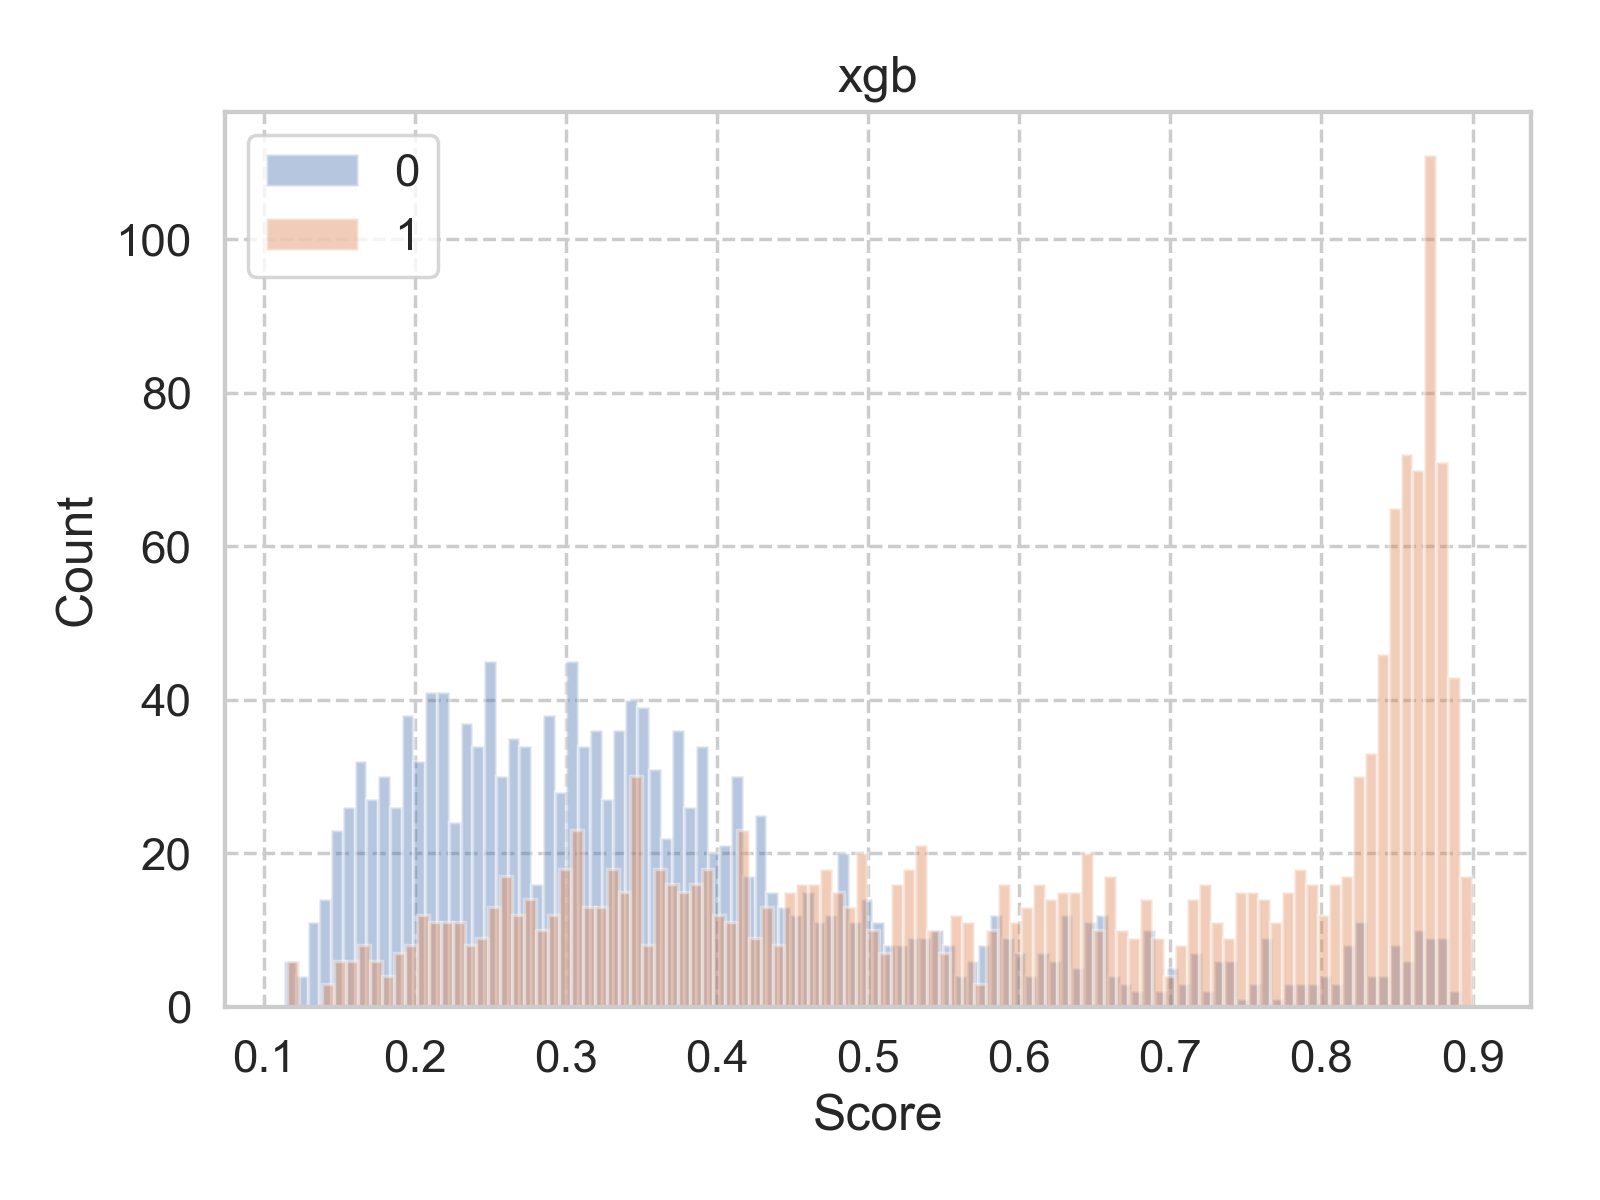

AUC:      0.715
Logloss:  0.676


<IPython.core.display.Javascript object>


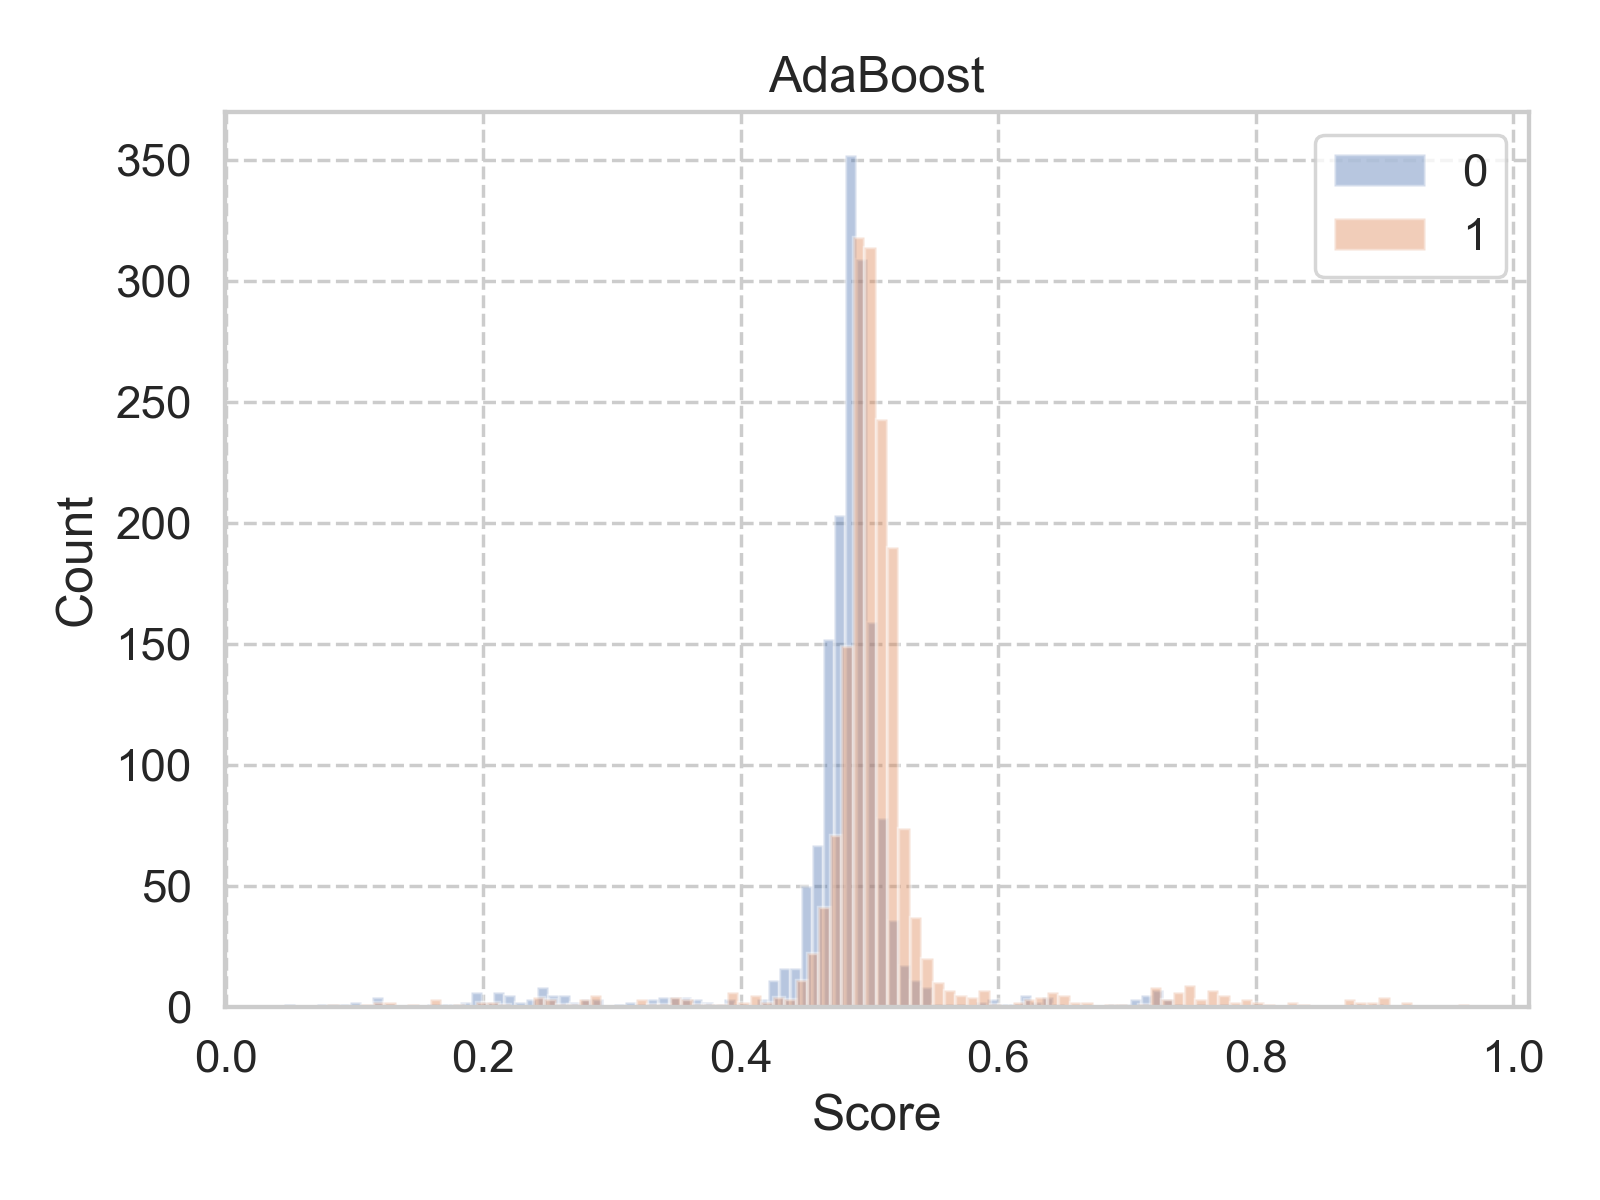

In [283]:
for i, x in enumerate(clfs):
    y_cal = pred_with_platt(X_test, y_test, x[0], x[-1])
    plot_prob_dist(y_cal, y_test, x[1], 10+i)